In [1]:
# Imports
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision

import matplotlib.pyplot as plt

import numpy as np

from pyro.distributions.relaxed_straight_through import RelaxedBernoulliStraightThrough

In [2]:
# Set seed for reproduciblity
torch.manual_seed(7212)
np.random.seed(2980)

In [3]:
# Hyper Parameters
EPOCH = 10
BATCH_SIZE = 64
LR = 0.005         # learning rate
DOWNLOAD_MNIST = False
N_TEST_IMG = 5

In [4]:
# Mnist digits dataset (download if necessary)
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,
    transform=torchvision.transforms.ToTensor(),                        
    download=DOWNLOAD_MNIST,
)

In [5]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# Select which device to use, use the gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Currently running on:", device)

Currently running on:  cuda


In [7]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
#             nn.Tanh(),
#             nn.Linear(128, 64),
#             nn.Tanh(),
#             nn.Linear(64, 32),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
#             nn.Linear(32, 64),
#             nn.Tanh(),
#             nn.Linear(64, 128),
#             nn.Tanh(),
            nn.Linear(128, 256),
            nn.Tanh(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        binary_encoded = RelaxedBernoulliStraightThrough(0.01, logits=encoded).rsample()
        
        # mask the binary data with random noise
        x,y = binary_encoded.shape
        mask= np.where([[0 if i < k else 1 for i in range(y)] for k in [np.random.randint(0, y+1) for _ in range(x)]])
        binary_encoded[mask] = torch.distributions.Bernoulli(probs=(torch.ones(x,y)/2)).sample().to(device)[mask]
        
        decoded = self.decoder(binary_encoded)
        return binary_encoded, decoded

Epoch:  0 | train loss: 0.2359


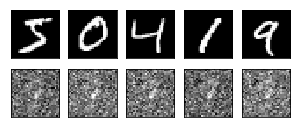

Epoch:  0 | train loss: 0.0499


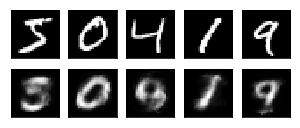

Epoch:  5 | train loss: 0.0423


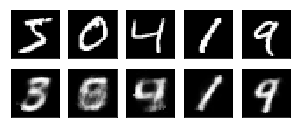

Epoch:  5 | train loss: 0.0418


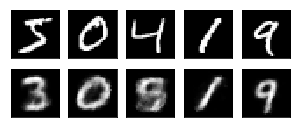

Epoch:  9 | train loss: 0.0400


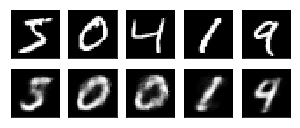

Epoch:  9 | train loss: 0.0419


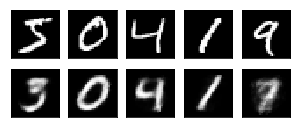

In [8]:
autoencoder = AutoEncoder().to(device)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss().to(device)

# original data (first row) for viewing
view_data = train_data.data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor).to(device)

for epoch in range(EPOCH):
    for step, (x, _) in enumerate(train_loader):
        batch = x.view(-1, 28*28).to(device)
        
        encoded, decoded = autoencoder(batch)
        
        loss = loss_func(decoded, batch)   # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 500 == 0 and (epoch % 5 == 0 or epoch == EPOCH-1):        
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            # initialize figure
            f, a = plt.subplots(2, N_TEST_IMG, figsize=(5, 2))
            
            for i in range(N_TEST_IMG):
                a[0][i].imshow(np.reshape(view_data.data.cpu().numpy()[i], (28, 28)), cmap='gray'); a[0][i].set_xticks(()); a[0][i].set_yticks(())
    
            for i in range(N_TEST_IMG):
                a[1][i].clear()
                a[1][i].imshow(np.reshape(decoded_data.data.cpu().numpy()[i], (28, 28)), cmap='gray')
                a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show(); plt.pause(0.05)
            
            
torch.cuda.empty_cache()